In [1]:
import numpy as np
import tensorflow as tf
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from math import inf

In [2]:
print(f' TensorFlow version: {tf.__version__}')
print(f' NumPy versio: {np.__version__}')

 TensorFlow version: 2.10.0
 NumPy versio: 1.23.4


## Algorithms implementation

### Utils

In [3]:
def dbscan(x):
    x_list = x.tolist()
    clustering = DBSCAN(eps=2).fit(x.reshape(-1, 1))
    x_labels = clustering.labels_.tolist()
    clusters = [[] for _ in range(max(x_labels)+1)]
    noice = []
    for i in range(len(x_list)):
        if x_labels[i] == -1:
            noice.append(x_list[i])
        else:
            clusters[x_labels[i]].append(x_list[i])
    return clusters, noice

### Stage 1 - Flow clustering

In [4]:
def subset_of_sets(_set: set, sets):
    return len([_ for s in sets if all([x in s for x in _set])]) > 0


def tp_cluster(clusters: set, noise: set, tp_ratio: float, tp_deviation: float):
    """
        Parameters :
            clusters : set
                Set of DBSCAN cluster sets in descending throughput order
            noise : set
                Set of DBSCAN noice flows
            tp_ratio : float
                Ratio used to determine if two DBSCAN clusters can be combined into one TPCluster
            tp_deviation : float
                The relative distance a noise flow can be away from a TPCluster to be assigned to that cluster

        Returns :
            cs : set
                set of TPClusters
    """

    r = 0
    cs = []
    for cluster in clusters:
        if not subset_of_sets(cluster, cs):
            cs.append(cluster)
            m = max(cluster)
            for cluster_k in clusters:
                if cluster_k is cluster: continue
                m_prim = max(cluster_k)
                if (1 - tp_ratio) * m < m_prim < m:
                    cs[r] += cluster_k
            r += 1
    for n_j in noise:
        delta_min = inf
        a = None
        for i in range(len(cs)):
            m = max(cs[i])
            if (-tp_deviation * m) <= (m - n_j) <= delta_min:
                delta_min = m - n_j
                a = i
        if a:
            cs[a].append(n_j)
        else:
            cs[0].append(n_j)
    return cs


### Stage 2 - FOF computation

In [5]:
def compute_fof(cs):
    """
        Parameters:
            cs : list of TPClusters

        Returns:
            f: 2d list
                FOF score for each flow in each cluster
            trace : dict
                dictionary mapping throughput to fof score

    """
    f = [[_ for _ in c_i] for c_i in cs]
    trace = dict()
    k = len(cs)
    for i in range(k):
        c_np = np.array(cs[i])
        s_labels = KMeans(n_clusters=k).fit(c_np.reshape((-1, 1))).labels_
        s_count = max(s_labels) + 1
        c_prim = 0
        for s_i in range(s_count):
            c_prim = max(c_prim, np.sum(c_np * (s_labels == s_i)) / np.sum(s_labels == s_i))
        for j in range(len(cs[i])):
            f[i][j] = np.abs(cs[i][j] - c_prim) / np.abs(c_prim)
            trace[cs[i][j]] = f[i][j]
    return f, trace


### Flow tracing

In [6]:
def compute_nlof_score(links, trace, gamma):
    """
        Parameters:
            links : 2d list
                links, each link contains list of flows (throughput)
            trace : dict
                dictionary mapping throughput to fof score
            gamma : float
                Outlier treshold

        Returns:
            scores : list
                nlof scores for each link
    """
    scores = [0 * len(links)]
    for i in range(len(links)):
        r = 0
        for j in range(len(links[i])):
            if trace[links[i][j]] > gamma :
                r += 1
        scores[i] = r / len(links[i])
    return scores


## Testing

In [7]:
# dbscan test
X1 = np.random.normal(10, 1, 10)
X2 = np.random.normal(20, 1, 10)
X3 = np.random.normal(30, 1, 10)
X = np.concatenate((X1, X2, X3, np.array([0])), axis=0)
print(dbscan(X))

([[10.16904829896689, 9.013407251038288, 10.74897425738573, 10.092729788936698, 9.483175960018587, 9.094416701552658, 10.041010668586999, 8.551979026843924, 7.905921768578798, 9.6371263176968], [19.660847297541068, 20.661873414769943, 18.03817594466103, 18.53777455433735, 22.047048298883514, 19.362017243537526, 20.77326362596945, 19.611089110047246, 18.798554981107667, 21.96626806407906], [30.87427035532167, 30.585110423088555, 29.25313739265998, 28.615935840339166, 30.209031777599517, 30.201089771488025, 29.79203552725913, 29.46489182533528, 30.04300343023502, 31.50847631959021]], [0.0])


In [8]:
# k_means test
Y = np.random.normal(10, 1, 10)
k_means = KMeans(n_clusters=4).fit(X.reshape(-1, 1)).labels_
print(Y)
print(k_means)
print(np.sum(X * (k_means == 0)) / np.sum(k_means == 0))

[10.25869933 10.27066869  8.35974943  9.75411266 10.14089358  9.40487923
 10.44568236  9.16328806 10.02813066 11.37165016]
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 3]
19.945691253493386


In [9]:
# Stage 1 test
print("X:", X)
clusters, noise = dbscan(X)
print("Clusters and noise:", clusters, noise)
tpc = tp_cluster(clusters, noise, 0.2, 0.2)

X: [10.1690483   9.01340725 10.74897426 10.09272979  9.48317596  9.0944167
 10.04101067  8.55197903  7.90592177  9.63712632 19.6608473  20.66187341
 18.03817594 18.53777455 22.0470483  19.36201724 20.77326363 19.61108911
 18.79855498 21.96626806 30.87427036 30.58511042 29.25313739 28.61593584
 30.20903178 30.20108977 29.79203553 29.46489183 30.04300343 31.50847632
  0.        ]
Clusters and noise: [[10.16904829896689, 9.013407251038288, 10.74897425738573, 10.092729788936698, 9.483175960018587, 9.094416701552658, 10.041010668586999, 8.551979026843924, 7.905921768578798, 9.6371263176968], [19.660847297541068, 20.661873414769943, 18.03817594466103, 18.53777455433735, 22.047048298883514, 19.362017243537526, 20.77326362596945, 19.611089110047246, 18.798554981107667, 21.96626806407906], [30.87427035532167, 30.585110423088555, 29.25313739265998, 28.615935840339166, 30.209031777599517, 30.201089771488025, 29.79203552725913, 29.46489182533528, 30.04300343023502, 31.50847631959021]] [0.0]


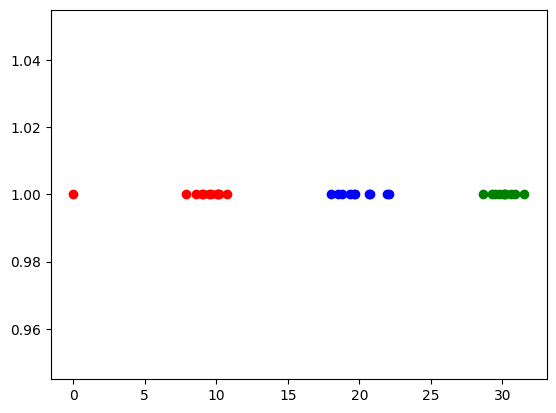

In [10]:
plt.scatter(np.array(tpc[0]), np.ones((1, len(tpc[0]))), color ='red')
plt.scatter(np.array(tpc[1]), np.ones((1, len(tpc[1]))), color = 'blue')
plt.scatter(np.array(tpc[2]), np.ones((1, len(tpc[2]))), color = 'green')

In [11]:
# Stage 2 test
print(compute_fof(tpc))

([[0.013996935257718824, 0.10123670769554265, 0.07182369811937611, 0.006386907947502094, 0.05439416971345916, 0.09315892773683905, 0.0012297852761359571, 0.1472475822059952, 0.21166856444760734, 0.03904315688727383, 1.0], [0.10659550689591885, 0.06110808627195316, 0.1803309800194812, 0.15762882299244407, 0.0018353589658704856, 0.12017458153502097, 0.05604642673778357, 0.10885655839603683, 0.14577875358982278, 0.0018353589658703243], [0.010166368075671691, 0.019436877876722346, 0.062140128420329684, 0.08256890356360416, 0.031494014361874365, 0.03174863624163477, 0.04486297525464913, 0.05535125027814749, 0.036816907508266265, 0.010166368075671691]], {10.16904829896689: 0.013996935257718824, 9.013407251038288: 0.10123670769554265, 10.74897425738573: 0.07182369811937611, 10.092729788936698: 0.006386907947502094, 9.483175960018587: 0.05439416971345916, 9.094416701552658: 0.09315892773683905, 10.041010668586999: 0.0012297852761359571, 8.551979026843924: 0.1472475822059952, 7.905921768578798: